<a href="https://colab.research.google.com/github/NickPavlovskii/sber/blob/main/sber_prediction_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задача: необходимо построить модель, которая оценивает обьем стабильной части средств на дату.


-  сделать прогноз объема расчетных счетов физических лиц на 1М, 2М, 3М...или др, 
- далее расчитывать минимальное значение объема `value` за данный промежуток. 

То есть после того, как сделал прогноз на промежуток 1 месяц, необходимо определить значение, ниже которого не опускается объема расчетных счетов физических лиц. 





- попробоать Квантильную регрессию 
- попробовать применить нормализацию данных (привести к некоторой шкале, но может и ухудшить предсказания) (http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html)

-  попробовать модель градиентного бустинга на деревьях, например посмотреть такой туториал (https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html)






 оглавление для проверяющего:\
[1. Подготовка данных](#step_0) \
[2. Модель 1](#step_1)\
[3. Модель 2](#step_2) \
[4. Минимум в месяц](#step_3) \
[5. Skforecast](#step_4) \
[6. Обогатим данные](#step_5) \
[7. Решение Сбера](#step_6) 

Загрузим данные и посмотрим на них

In [355]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
# для исследования сезонности, тренда в данных
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score

from pylab import rcParams

import warnings
import itertools

# для форматирования графиков
%matplotlib inline
plt.rcParams.update({'font.size': 15, 
                     'figure.figsize': (18, 8), 
                     'axes.grid' : True})

<a id='step_0'></a>
# Подготовка данных

In [356]:
columns=['Date', 'value']


dataset = pd.read_csv('data_1.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'], 
                   dayfirst=True, 
                   header=None, 
                   names=columns, 
                   infer_datetime_format="%d/%m/%y")

dataset.dropna(subset=['value'], how='all')


,value
Date,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-01-02,3417092149
2014-01-03,3417092149
...,...
2019-10-06,64630140507
2019-10-07,66115288637
2019-10-08,68424049766


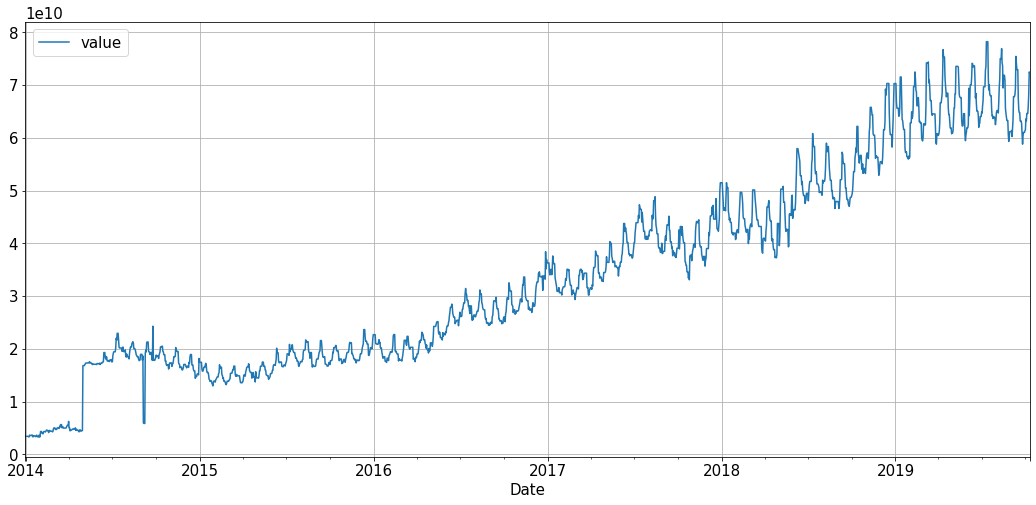

In [357]:



dataset.plot(y='value')

Уберем этот выброс

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """Entry point for launching an IPython kernel.


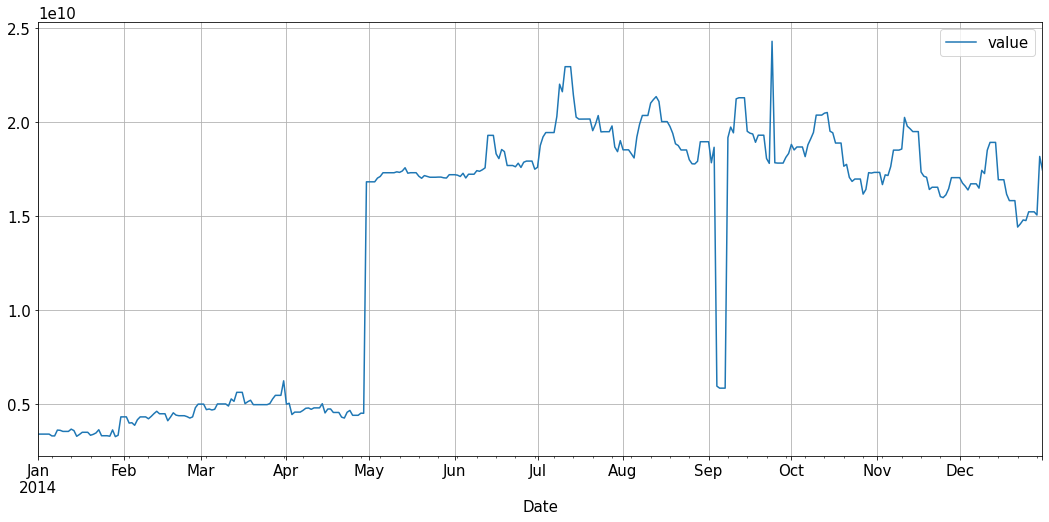

In [358]:

dataset['2014'].plot(y='value')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """Entry point for launching an IPython kernel.


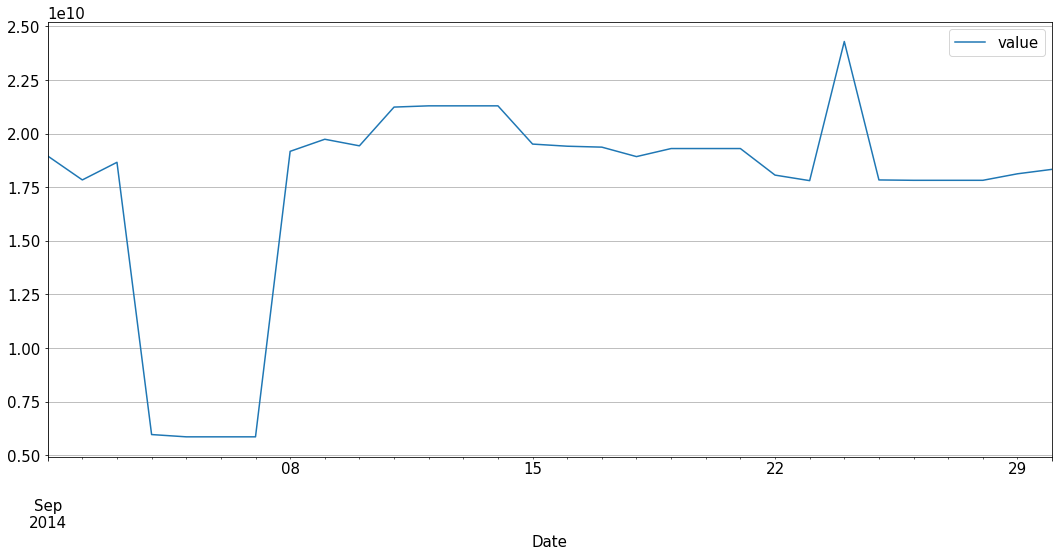

In [359]:
dataset['2014-09'].plot(y='value')


In [360]:
dataset=dataset.drop(['2014-09-02','2014-09-03','2014-09-04','2014-09-05','2014-09-06','2014-09-07','2014-09-23','2014-09-24','2014-09-25'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  """Entry point for launching an IPython kernel.


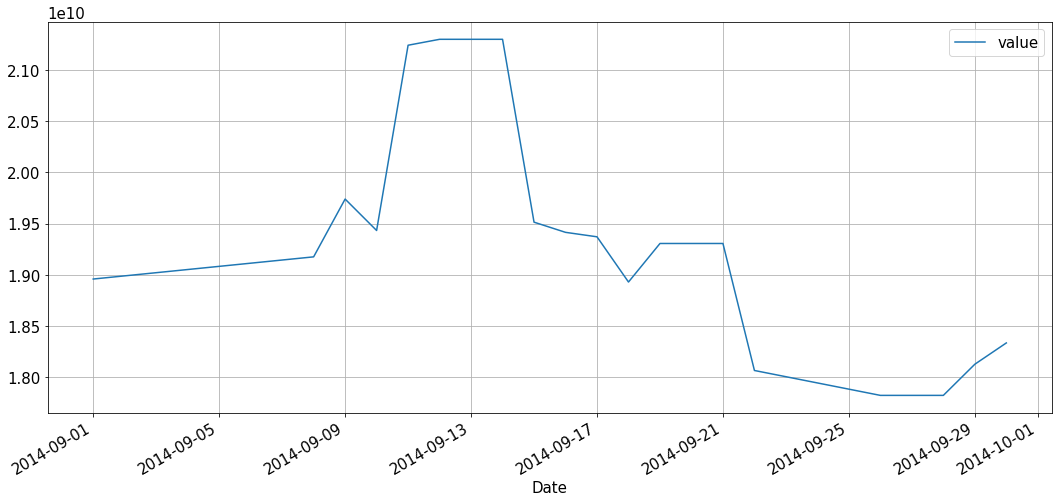

In [361]:
dataset['2014-09'].plot(y='value')


In [362]:
dataset.info() 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2102 entries, 2013-12-30 to 2019-10-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   2102 non-null   int64
dtypes: int64(1)
memory usage: 32.8 KB


In [363]:
print(f'Number of rows with missing values: {dataset.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


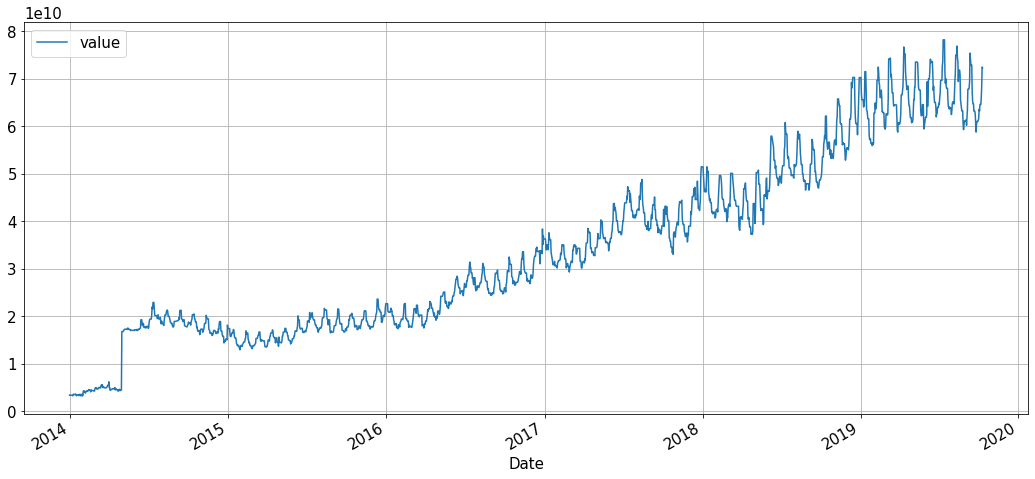

In [364]:
dataset.plot(y='value')

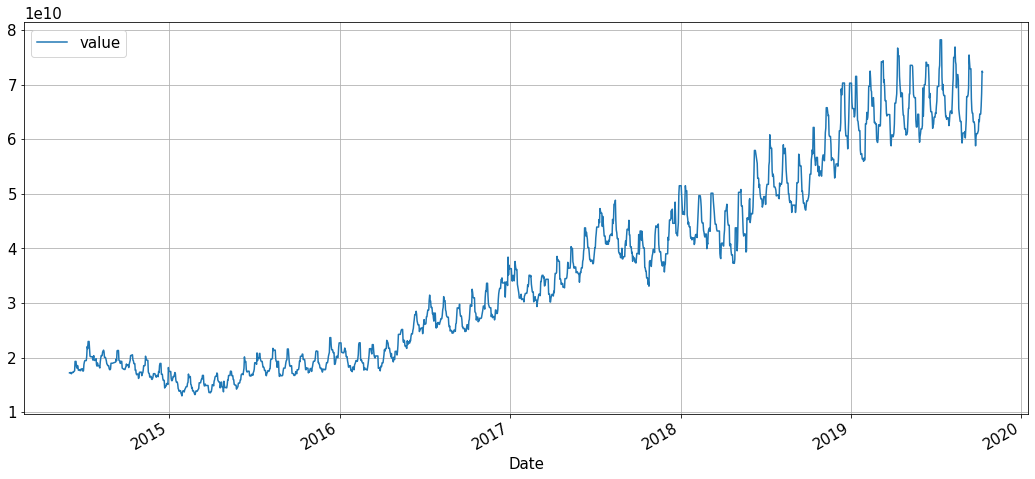

In [365]:
dataset=dataset['2014-06':]
dataset.plot(y='value')

In [366]:
# Определяем функцию для теста ADF
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    # Выполняем тест Дики-Фуллера:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# применяем к ряду тест adf 
adf_test(dataset)

Results of Dickey-Fuller Test:
Test Statistic                    0.890555
p-value                           0.992966
#Lags Used                       26.000000
Number of Observations Used    1922.000000
Critical Value (1%)              -3.433757
Critical Value (5%)              -2.863045
Critical Value (10%)             -2.567571
dtype: float64


Видим,что график имеет выбросы. Так анализировать закрытие/открытие счетов за каждые день не имеет смысла, поэтому перейдем к неидеальному интервалу и среднему значению счетов на нем, тем самым уменьшим колебания нашего временного ряда

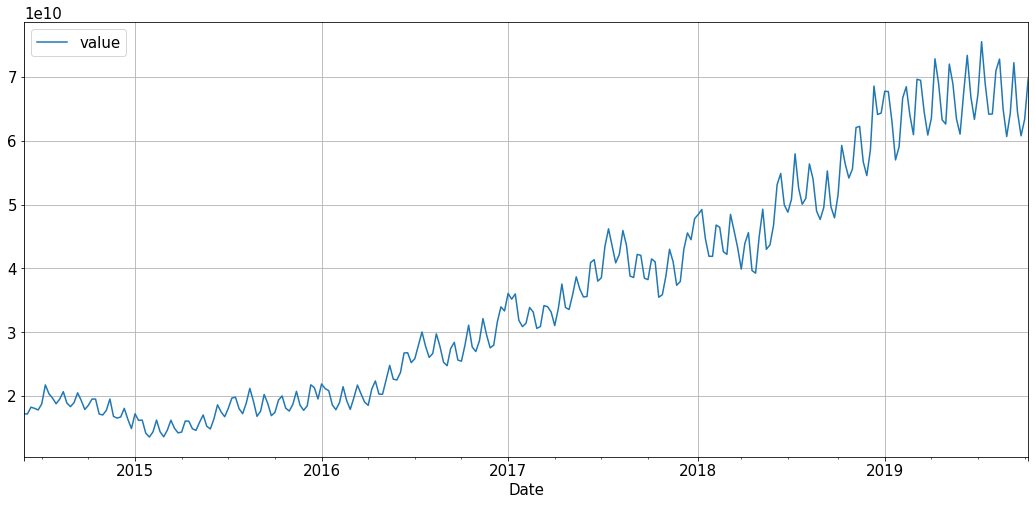

In [367]:
dataset1 = dataset.resample('W').agg('mean')

dataset1.plot(y='value')

In [368]:
dt = pd.read_csv('data_1.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'], 
                   dayfirst=True, 
                   header=None, 
                   names=columns, 
                   infer_datetime_format="%d/%m/%y")

dt.dropna(subset=['value'], how='all')

,value
Date,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-01-02,3417092149
2014-01-03,3417092149
...,...
2019-10-06,64630140507
2019-10-07,66115288637
2019-10-08,68424049766


In [369]:
dataset1 = dataset1.interpolate()

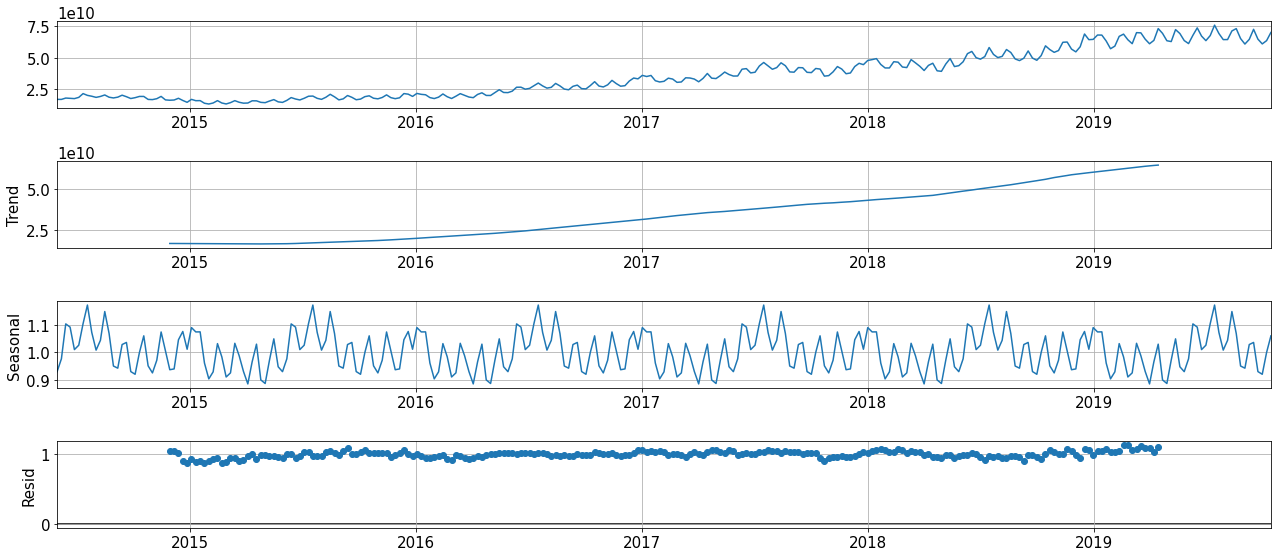

In [370]:
ts_dicomposition = seasonal_decompose(dataset1, model='multiplicate')
ts_dicomposition.plot();


График не имеет ярких выбрлсов и имеет закономерность, значит ряд  не стационарный.

,value
count,2.810000e+02
mean,3.601189e+10
std,1.776124e+10
min,1.356953e+10
25%,1.930714e+10
50%,3.317428e+10
75%,4.882917e+10
max,7.556869e+10


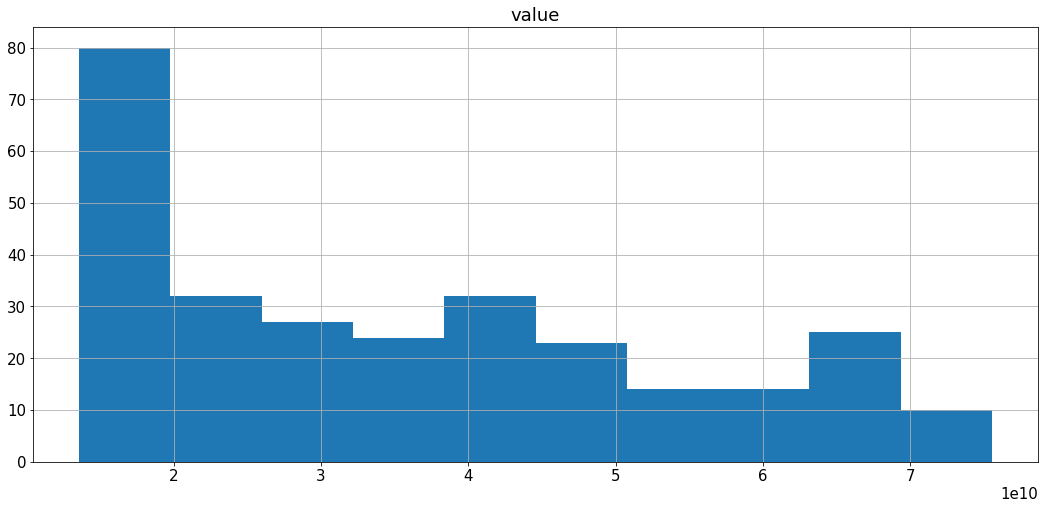

In [371]:
itog = dataset1.describe()
dataset1.hist()
itog

Заметим не однородный график. Посчитаем коэффициент вариации.

In [373]:
from statsmodels.iolib.table import SimpleTable
import numpy as np
from statsmodels.stats.stattools import jarque_bera  
row=[u'JB',u'p-value',u'skew',u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(dataset1)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print (itog)


         JB         
--------------------
  24.836828228417446
4.04344254308925e-06
  0.5372387132126283
   2.016743574767504
--------------------


In [ ]:
test = sm.tsa.adfuller(dataset1)

print(f'adf: {test[0]}') # может стоит использовать f-strings - форматирование строк
print('p-value: ', test[1])
print('Critical values: ', test[4])

if test[0] > test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

In [375]:
otgdiff = dataset1.diff(periods=1).dropna()

In [376]:
test = sm.tsa.adfuller(otgdiff)
print('adf:', test[0])
print('p-value:', test[1])
print('Critical values:', test[4])

if test[0] > test[4]['5%']:
    print('Есть единичные корни, ряд не стационарен')
else: 
    print('единичных корней нет,ряд стационарный')
    

adf: -5.874946960452744
p-value: 3.175618721642911e-07
Critical values: {'1%': -3.455365238788105, '5%': -2.8725510317187024, '10%': -2.5726375763314966}
единичных корней нет,ряд стационарный


Построим график и посмотрим на тренд для графика. 

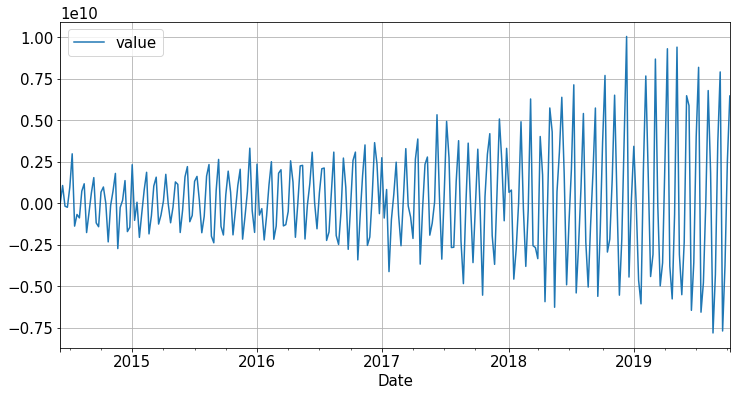

In [377]:
otgdiff.plot(figsize=(12,6))

Видим что тренда нет и таким образом ряд первых разностей является стационарным, а наш исходный ряд — интегрированным рядом первого порядка.

<a id='step_1'></a>

# Модель 1

**Построение модели** 


Для моделирования будем использовать модель ARIMA, построенную для ряда первых разностей.
Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:
p — порядок компоненты AR
d — порядок интегрированного ряда
q — порядок компонетны MA

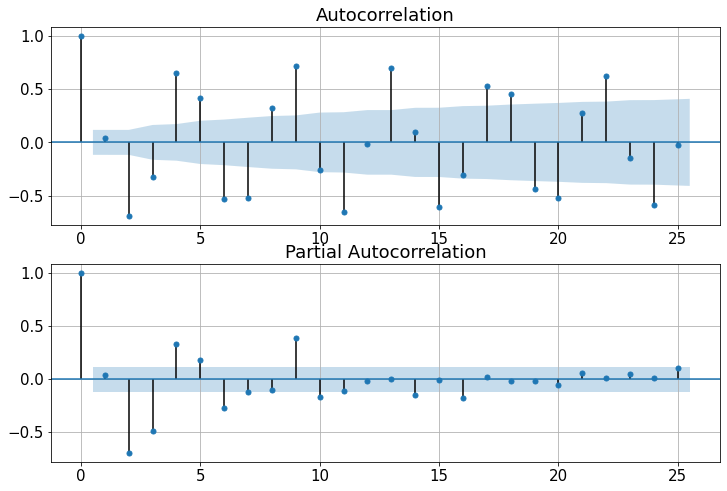

In [378]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(otgdiff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(otgdiff, lags=25, ax=ax2)

In [379]:
src_data_model = dataset1[:'2019-06-10']
model = sm.tsa.ARIMA(src_data_model, order=(2, 1, 2), freq='W').fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available',

In [380]:
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  262
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -5942.154
Method:                       css-mle   S.D. of innovations     1629539807.795
Date:                Wed, 21 Sep 2022   AIC                          11896.308
Time:                        19:50:37   BIC                          11917.718
Sample:                    06-08-2014   HQIC                         11904.913
                         - 06-09-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.921e+08        nan        nan        nan         nan         nan
ar.L1.D.value     0.2520        nan        nan        nan         nan         nan
ar.L2.D.value    -1.0000        nan     

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1521: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


In [381]:
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


In [382]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error,r2_score
pred = model.predict('2019-05-26','2020-12-31', typ='levels')
trn = dataset1['2019-05-26':]
r2 = r2_score(trn, pred[0:len(trn)])
print ('R^2: %1.2f' % r2)
print('Mean Squared Error:', metrics.mean_squared_error(trn, pred[0:len(trn)]))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(trn, pred[0:len(trn)])))
print('Mean Absolute Error:', metrics.mean_absolute_error(trn, pred[0:len(trn)])) 

R^2: 0.64
Mean Squared Error: 6.698681560004056e+18
Root Mean Squared Error: 2588181129.674671
Mean Absolute Error: 1995610361.8549478


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


nan был из-за того что в данных были пропуски

In [383]:
# metrics.rmse(trn, pred[0:len(trn)])

Попробуем предсказать...

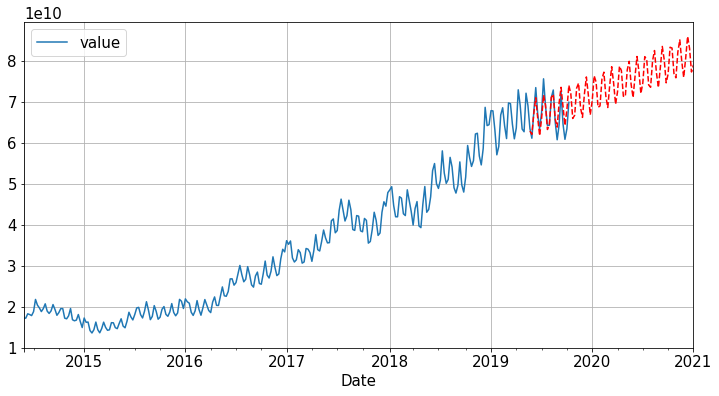

In [384]:
dataset1.plot(figsize=(12,6))
pred.plot(style='r--');


In [421]:
dt_pred=dataset1['2019-05-15':]


dt_pred['pred']=predictions
dt_pred.head(15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,value,pred
Date,,
2019-05-19,6.896488e+10,6.475304e+10
2019-05-26,6.344489e+10,6.474227e+10
2019-06-02,6.107306e+10,6.475304e+10
2019-06-09,6.754772e+10,6.475304e+10
2019-06-16,7.342399e+10,6.475304e+10
2019-06-23,6.696145e+10,6.481112e+10
2019-06-30,6.337888e+10,6.475304e+10
2019-07-07,6.738229e+10,6.475304e+10
2019-07-14,7.556869e+10,6.475304e+10


Как можно улучшть качество предсказаний?

Попробуем еще предсказать ряд..

<a id='step_2'></a>

# Сезонность и SARIMA

Куча ошибок и не понятно что вообще, пока оставим

In [386]:
columns=['Date', 'value']
dt = pd.read_csv('data_1.csv', parse_dates=['Date'], dayfirst=True, header=None, names=columns)
dt['year'] = dt['Date'].dt.year
dt['month'] = dt['Date'].dt.month
dt['day'] = dt['Date'].dt.day
dt.dropna(subset=['value'], how='all')
dt=dt.set_index('Date')
dt


,value,year,month,day
Date,,,,
2013-12-30,3457625638,2013,12,30
2013-12-31,3417092149,2013,12,31
2014-01-01,3417092149,2014,1,1
2014-02-01,3417092149,2014,2,1
2014-03-01,3417092149,2014,3,1
...,...,...,...,...
2019-06-10,64630140507,2019,6,10
2019-07-10,66115288637,2019,7,10
2019-08-10,68424049766,2019,8,10


разложим временной ряд на три отдельных компонента: тренд, сезонность и шум.

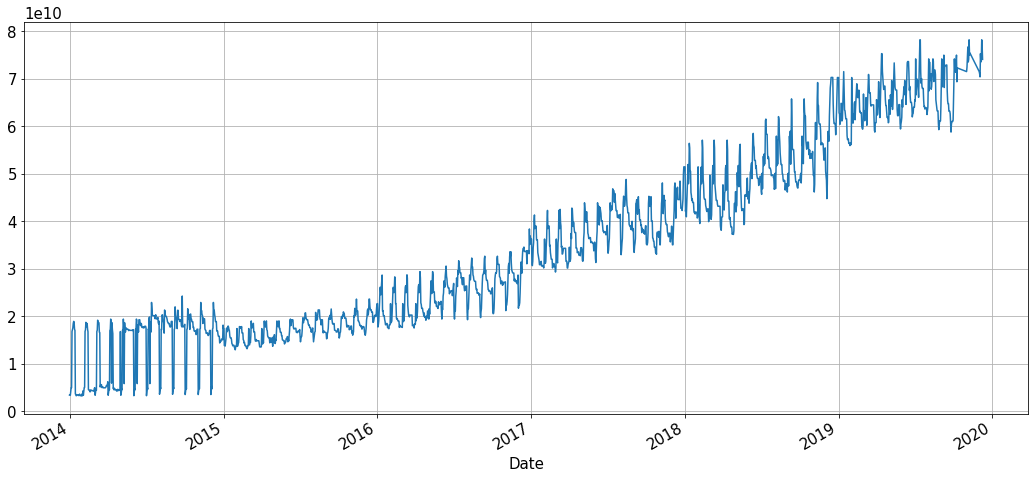

In [387]:


dt['value'].plot();


In [388]:
df_test = dt[-30:]
df_train = dt[:-50]

In [389]:
m_df_train = df_train.asfreq('M')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


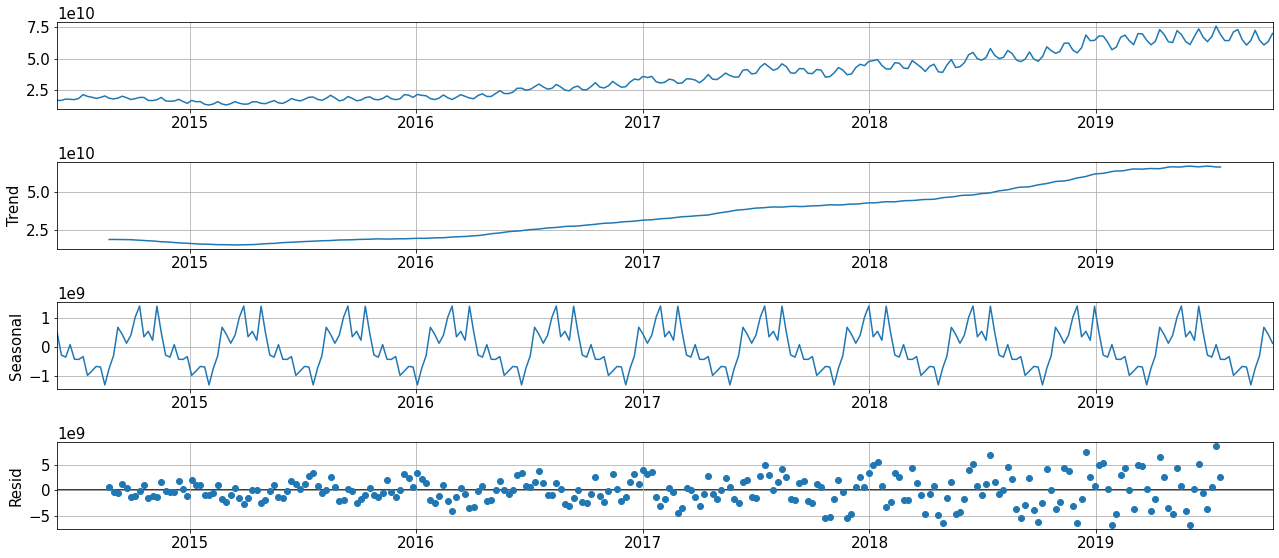

In [390]:
ts_dicomposition = seasonal_decompose(dataset1, freq=24)
ts_dicomposition.plot();


In [391]:
seasonal_prediction = pd.DataFrame(sd.seasonal)
seasonal_prediction['month'] = seasonal_prediction.index.month

In [392]:
seasonal_prediction = seasonal_prediction.groupby('month', as_index=False).first()

In [393]:
df_train = df_train.reset_index().merge(
    seasonal_prediction, 
    how='left', 
    left_on='month', 
    right_on='month'
).set_index('Date')


In [394]:
df_train['tren_resid']=df_train['value']- df_train['seasonal']

In [395]:
mod = sm.tsa.statespace.SARIMAX(df_train.tren_resid,
order=(2, 1, 2),
seasonal_order=(1, 1, 1, 12)
)
results = mod.fit()
print(results.summary().tables[1])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2307      0.195      1.185      0.236      -0.151       0.612
ar.L2          0.5681      0.155      3.671      0.000       0.265       0.871
ma.L1         -0.4682      0.204     -2.295      0.022      -0.868      -0.068
ma.L2         -0.4978      0.195     -2.559      0.011      -0.879      -0.116
ar.S.L12      -0.0268      0.055     -0.489      0.625      -0.134       0.081
ma.S.L12      -0.9760      0.017    -58.463      0.000      -1.009      -0.943
sigma2      8.566e+18   2.28e-20   3.76e+38      0.000    8.57e+18    8.57e+18


In [419]:
pred = mod.predict('2019-05-26','2020-12-31', typ='levels')

NotImplementedError: ignored

In [ ]:
# Sarimax
model = sm.tsa.statespace.SARIMAX(
    df_train.tren_resid, 
    order=(0, 1, 1) # tune/optimiz!
  
) 

model_fit = model.fit(disp=0)

In [ ]:
df_test = df_test.reset_index().merge(
    seasonal_prediction, 
    how='left', 
    left_on='month', 
    right_on='month').set_index('Date')

In [ ]:
df_test['predict'] = mod.predict(start='2019-09-10', end='2019-10-12', dynamic=True)

In [ ]:
df_test['predict_final'] = df_test['predict'] + df_test['seasonal']

In [ ]:
df_test[['value','predict_final']].plot(figsize=(12,8))

Попробовать квантильную регрессию?

# Минимум в месяц

предскажем минимальное значение объема,при подготовке обучающих данных при группировке по месяцу возьмем минимальные значения.

**mint∈time(value0..valuet)**











In [397]:


df_min=dataset.groupby(pd.Grouper( axis=0, 
                      freq='m')).min()
                      
df_min                  

,value
Date,
2014-06-30,17032963159
2014-07-31,17600814179
2014-08-31,17778268294
2014-09-30,17824637391
2014-10-31,16175563049
...,...
2019-06-30,61914946300
2019-07-31,62498180060
2019-08-31,59314626057


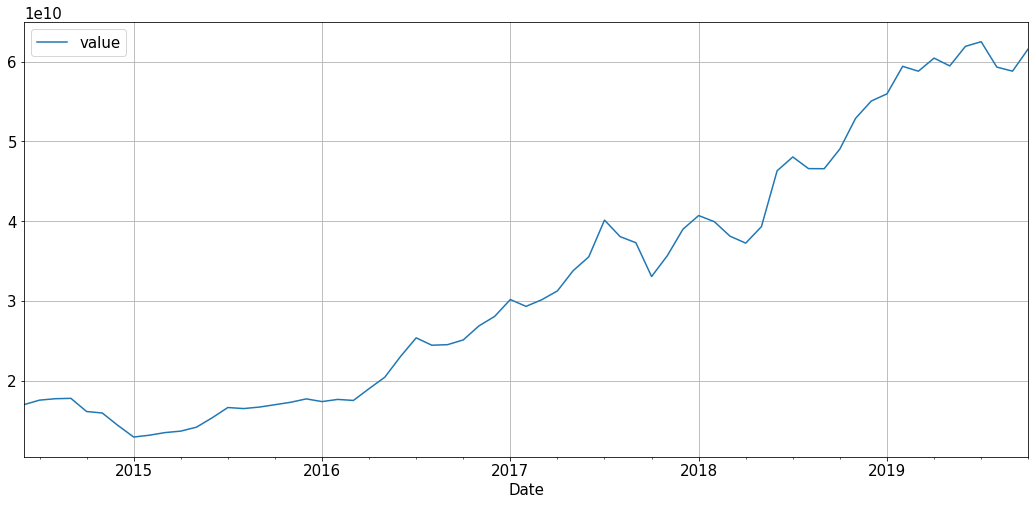

In [398]:
df_min.plot(y='value')




Train dates : 2014-06-30 00:00:00 --- 2019-05-31 00:00:00  (n=60)
Test dates  : 2019-06-30 00:00:00 --- 2019-10-31 00:00:00  (n=5)


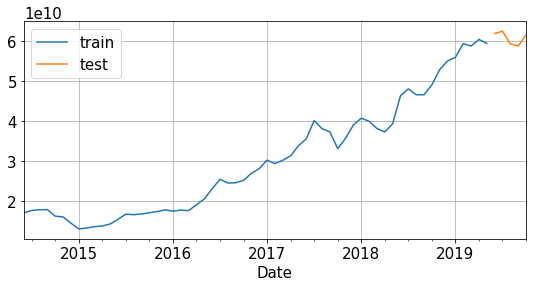

In [426]:
steps = 5
data_train = df_min[:-steps]
data_test  = df_min[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
ax.legend();

In [400]:
pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [401]:

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

In [403]:
# ==============================================================================
steps = 36

predictions = forecaster.predict(steps=steps)


data_test['pred']=predictions
data_test.head(15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,value,pred
Date,,
2019-06-30,61914946300,5.880050e+10
2019-07-31,62498180060,5.932286e+10
2019-08-31,59314626057,5.923544e+10
2019-09-30,58806294388,5.944610e+10
2019-10-31,61596050079,5.944709e+10


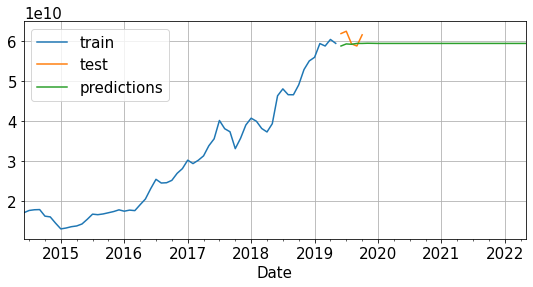

In [404]:
# Plot
# ==============================================================================


fig, ax = plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

С помощью чего предсказать мин значения? Существенно меньше данных стало ((

XGBoost? Arima? What?

# Skforecast

Попробуем библиотеку Skforecast (спойлер предсказания тоже такие себе) 

Train dates : 2014-06-01 00:00:00 --- 2019-02-03 00:00:00  (n=245)
Test dates  : 2019-02-10 00:00:00 --- 2019-10-13 00:00:00  (n=36)


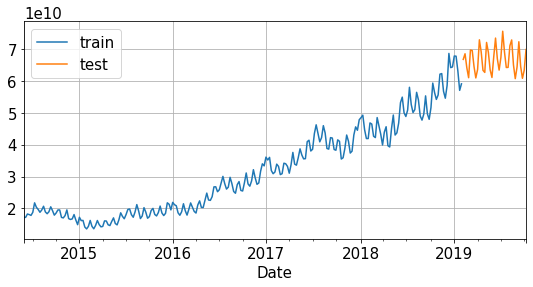

In [405]:
steps = 36
data_train = dataset1[:-steps]
data_test  = dataset1[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
ax.legend();

In [406]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
                )

forecaster.fit(y=data_train['value'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2014-06-01 00:00:00'), Timestamp('2019-02-03 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-SUN 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-09-21 19:51:21 
Last fit date: 2022-09-21 19:51:21 
Skforecast version: 0.4.3 

In [407]:
# Predictions
# ==============================================================================
steps = 36

predictions = forecaster.predict(steps=steps)


data_test['pred']=predictions
data_test.head(15)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,value,pred
Date,,
2019-02-10,6.674185e+10,6.140721e+10
2019-02-17,6.850709e+10,6.230516e+10
2019-02-24,6.408280e+10,6.099774e+10
2019-03-03,6.099172e+10,6.280820e+10
2019-03-10,6.967669e+10,6.396835e+10
2019-03-17,6.951006e+10,6.536895e+10
2019-03-24,6.452308e+10,6.549136e+10
2019-03-31,6.092624e+10,6.572042e+10
2019-04-07,6.357528e+10,6.544398e+10


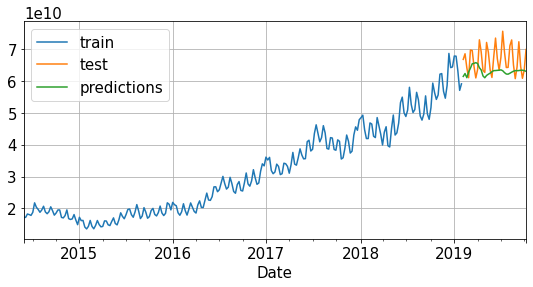

In [408]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [409]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['value'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 3.0806186296482873e+19


In [410]:
# Hyperparameter Grid search
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20,30,40]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500,1000],
              'max_depth': [3, 5, 10,15,20]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['value'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 60


loop lags_grid: 100%|██████████████████████████████████████| 4/4 [10:18<00:00, 154.62s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] 
  Parameters: {'max_depth': 20, 'n_estimators': 100}
  Backtesting metric: 4.0414810266602275e+19



In [411]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,metric,max_depth,n_estimators
57,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'n_estimators': 100}",4.041481e+19,20,100
54,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 15, 'n_estimators': 100}",4.041481e+19,15,100
55,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 15, 'n_estimators': 500}",4.051118e+19,15,500
58,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'n_estimators': 500}",4.051118e+19,20,500
52,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",4.072704e+19,10,500
59,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 20, 'n_estimators': 1000}",4.083193e+19,20,1000
56,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 15, 'n_estimators': 1000}",4.083193e+19,15,1000
53,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 1000}",4.093080e+19,10,1000
51,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",4.100520e+19,10,100
49,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",4.114930e+19,5,500


In [412]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=15, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 40
             )

forecaster.fit(y=data_train['value'])

In [413]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

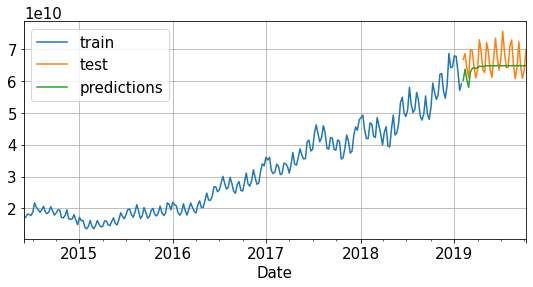

In [414]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['value'].plot(ax=ax, label='train')
data_test['value'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [415]:
predictions

2019-02-10    6.014645e+10
2019-02-17    6.365778e+10
2019-02-24    6.045317e+10
2019-03-03    5.794471e+10
2019-03-10    6.280293e+10
2019-03-17    6.387415e+10
2019-03-24    6.418641e+10
2019-03-31    6.385605e+10
2019-04-07    6.411368e+10
2019-04-14    6.459136e+10
2019-04-21    6.451838e+10
2019-04-28    6.454352e+10
2019-05-05    6.462140e+10
2019-05-12    6.475368e+10
2019-05-19    6.475304e+10
2019-05-26    6.474227e+10
2019-06-02    6.475304e+10
2019-06-09    6.475304e+10
2019-06-16    6.475304e+10
2019-06-23    6.481112e+10
2019-06-30    6.475304e+10
2019-07-07    6.475304e+10
2019-07-14    6.475304e+10
2019-07-21    6.475304e+10
2019-07-28    6.475304e+10
2019-08-04    6.475304e+10
2019-08-11    6.475304e+10
2019-08-18    6.475304e+10
2019-08-25    6.475304e+10
2019-09-01    6.475304e+10
2019-09-08    6.475304e+10
2019-09-15    6.475304e+10
2019-09-22    6.475304e+10
2019-09-29    6.475304e+10
2019-10-06    6.475304e+10
2019-10-13    6.475304e+10
Freq: W-SUN, Name: pred, dty

# Обогатим данные

Попробуем обогатить данные и добавить курс $ и € 

In [416]:

dt_d = pd.read_csv('usd_quotes_1.csv',
                   index_col=['Date'], 
                   parse_dates=['Date'], 
                  
                   infer_datetime_format="%d/%m/%y")
dt_d

,doll
Date,
2022-09-21,60.0158
2022-09-20,60.1662
2022-09-19,60.0316
2022-09-18,60.0316
2022-09-17,60.0316
...,...
2014-06-07,34.6573
2014-06-06,34.9043
2014-06-05,35.1398


In [417]:
dataset_doll = dataset1.join(dt_d['doll']) # :(((
dataset_doll   

,value,doll
Date,,
2014-06-01,1.720682e+10,NaN
2014-06-08,1.718698e+10,NaN
2014-06-15,1.824927e+10,NaN
2014-06-22,1.806436e+10,NaN
2014-06-29,1.781468e+10,NaN
...,...,...
2019-09-15,7.227318e+10,NaN
2019-09-22,6.456505e+10,NaN
2019-09-29,6.080820e+10,NaN


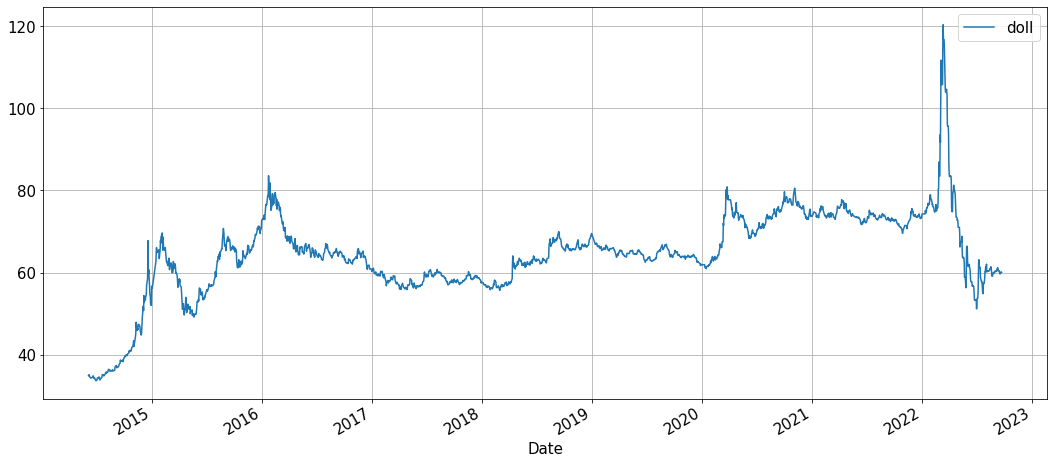

In [418]:
dt_d.plot(label='doll')


# Решение Сбера

В процессе